# 

## TODO: 

1. Split into train/validation/test data
2. Construct a testing apperatus. At minimum measure accuracy. Probably also things like F1. Maybe make a function which produces a list of the predicted labels along with a list of the true labels for comparison purposes?
3. Expand the testing apperatus to measure train and validation data.
4. Measure the validation loss and accuracy over time while training the model. Plot it.
5. Optimize model hyperparameters
6. Experiment with simple vs augmented. See if there is anything in augmented that makes sense to remove/add.
7. Test random/trained weights against pretrained/finetuned Alexnet weights.
8. Make code more efficient? Interestingly, at least when I run it on Kaggle with the GPU T4 x2, CPU is the bottleneck by a decent margin. Not GPU. Very possible that CPU related code can be improved/the model can be made to train a decent bit faster.
9. Organize/neaten up the notebook
10. Split notebook? Into one for training/saving the model and one for loading/testing it.
11. Model isn't training with the augmented. Adjust so that it does! (Be it augmented itself, the hyperparameters, etc.)

In [1]:
# General references

# https://github.com/fenicXs/Sickle-Cell-anemia-detection-using-Alexnet-based-CNN-architecture/blob/main/Sickle_cell_anemia_detection.ipynb
# https://pytorch.org/hub/pytorch_vision_alexnet/ -- Not yet used, but will probably be useful


# Define Supporting Methods

## Methods for loading the data

In [2]:
import torch
from torchvision.transforms import v2 # PyTorch image transformations
from PIL import Image # pillow library for opening images

import matplotlib.pyplot as plt

from torchvision.io import read_image
from torch.utils.data import Dataset
import os

In [3]:
# https://pytorch.org/vision/stable/transforms.html

def get_transform(mode:str):

    if mode == "simple":
        # Without Augmentations
        transform = v2.Compose([
            v2.ToDtype(torch.float32, scale=True), 
        	v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])

    elif mode == "augmented":
        # With Augmentations
        transform = v2.Compose([
            v2.ToDtype(torch.float32, scale=True),
        
            # flip image
            v2.RandomHorizontalFlip(p=0.5),
        	v2.RandomVerticalFlip(p=0.5),
        
            # rotate image by 90 degrees 0, 1, 2, or 3 times
            v2.RandomChoice([
                v2.Lambda(lambda image: torch.rot90(image, 0, [1, 2])), # 0 degrees 
                v2.Lambda(lambda image: torch.rot90(image, 1, [1, 2])), # 90 degrees 
                v2.Lambda(lambda image: torch.rot90(image, 2, [1, 2])), # 180 degrees
                v2.Lambda(lambda image: torch.rot90(image, 3, [1, 2])), # 270 degrees
            ]),
        
        	v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    else: 
        raise NotImplementedError

    return transform

In [4]:
def get_tot_files(main_dir):
    tot_len = 0
    for a_dir in os.walk(main_dir):
        tot_len = tot_len + len(a_dir[2])
    return tot_len

In [5]:
# https://www.geeksforgeeks.org/os-walk-python/
class CustomDataset(Dataset):
    def __init__(self, main_dir, transform=None):
        self.total_imgs = get_tot_files(main_dir)
        self.tot_healthy_imgs = get_tot_files(main_dir + "/Healthy")
        self.healthy_img_list = next(os.walk(main_dir + "/Healthy"))[2]
        self.anemic_img_list = next(os.walk(main_dir + "/Anemic"))[2]
        self.transform = transform
        self.main_dir = main_dir

    def __len__(self):
        return self.total_imgs

    def __getitem__(self, idx):
        if idx < self.tot_healthy_imgs:
            label = 0
            sub_dir = "Healthy"
            pos = idx
            img_name = self.healthy_img_list[pos]
        else:
            label = 1
            sub_dir = "Anemic"
            pos = idx - self.tot_healthy_imgs
            img_name = self.anemic_img_list[pos]
        
        img_dir = os.path.join(self.main_dir, sub_dir)
        img_path = os.path.join(img_dir, img_name)
        image = read_image(img_path)
        if self.transform:
            image = self.transform(image)
        
        return image, label

## Methods for creating the model

In [6]:
# https://stackoverflow.com/questions/66626700/difference-between-tensorflows-tf-keras-layers-dense-and-pytorchs-torch-nn-lin
import torch.nn as nn
import torch.nn.functional as F

class Alexnet(nn.Module):
    def __init__(self):
        super(Alexnet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 16, 3)
        self.flat1 = nn.Flatten()
        self.dense1 = nn.Linear(14400, 256)
        self.dense2 = nn.Linear(256, 1)

        self.pool1 = nn.MaxPool2d(2)
        self.pool2 = nn.MaxPool2d(2)
        self.pool3 = nn.MaxPool2d(2)
    def forward(self, z):
        out = F.relu(self.conv1(z))
        out = self.pool1(out)
        out = F.relu(self.conv2(out))
        out = self.pool2(out) 
        out = F.relu(self.conv3(out))
        out = self.pool3(out)  
        out = self.flat1(out)
        out = F.relu(self.dense1(out))
        out = F.sigmoid(self.dense2(out))
        return out

In [7]:
from tqdm import tqdm
import torch.optim as optim

def training_loop(dataloader, num_epochs, device="cpu", batch_size=16,
                  optimizer=optim.AdamW, loss_fn=nn.BCELoss(), print_loss=True, lr=.001):
    iter_list = []
    an_loss_list = []
    
    an_model = Alexnet().to(device)
    an_model.train()

    an_optimizer = optimizer(an_model.parameters(), lr=lr)
    
    iteration = 0
    for epoch in tqdm(range(num_epochs)):
        for data, labels in dataloader:
            images = data.to(device)
            img_labels = labels.to(device)

            an_model.zero_grad()
            
            an_loss = loss_fn(an_model(images)[:, 0], img_labels.float())

            an_loss.backward()
            an_optimizer.step()

            if (iteration+1) % 200 == 0:
                iter_list.append(iteration)
                an_loss_list.append(an_loss)
    
                if print_loss:
                    print(f"Iteration {iteration} during epoch {epoch}")
                    print(f"Alexnet loss: {an_loss}")
            
            iteration += 1

        if (epoch+1) % 5 == 0: 
            # Save the model every 5 epochs
            torch.save(an_model.state_dict(), f'an_model_weights_{epoch}_{lr}.pth')

    return iter_list, an_loss_list

# Training the Model

In [8]:
labels_map = {
    0: "Healthy",
    1: "Anemic"
}

device = ("cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu")
print(f"Using {device} device.")

Using cuda device.


In [9]:
from torch.utils.data import DataLoader

my_batch_size=64
my_epochs = 20
my_lr = 1e-3

dataset_path = "/kaggle/input/anemic-rbc-dataset-resized/Anemic_RBC_dataset_resized/"
training_data = CustomDataset(dataset_path, get_transform("simple"))
train_dataloader = DataLoader(training_data, shuffle=True, batch_size=my_batch_size, num_workers=3)

In [10]:
iter_list, an_loss_list = training_loop(train_dataloader, num_epochs=my_epochs, batch_size=my_batch_size,
                                        lr=my_lr, device=device, print_loss = True)

  5%|▌         | 1/20 [00:49<15:39, 49.47s/it]

Iteration 199 during epoch 1
Alexnet loss: 0.6930118799209595


 10%|█         | 2/20 [01:24<12:22, 41.23s/it]

Iteration 399 during epoch 2
Alexnet loss: 0.6939587593078613


 15%|█▌        | 3/20 [01:59<10:47, 38.07s/it]

Iteration 599 during epoch 3
Alexnet loss: 0.6875815391540527


 20%|██        | 4/20 [02:31<09:32, 35.80s/it]

Iteration 799 during epoch 4
Alexnet loss: 0.672940731048584


 25%|██▌       | 5/20 [03:03<08:35, 34.34s/it]

Iteration 999 during epoch 5
Alexnet loss: 0.5760326385498047


 30%|███       | 6/20 [03:33<07:41, 32.97s/it]

Iteration 1199 during epoch 6
Alexnet loss: 0.3984902501106262


 35%|███▌      | 7/20 [04:04<06:58, 32.23s/it]

Iteration 1399 during epoch 7
Alexnet loss: 0.2279827743768692


 40%|████      | 8/20 [04:34<06:20, 31.71s/it]

Iteration 1599 during epoch 8
Alexnet loss: 0.249196857213974


 45%|████▌     | 9/20 [05:06<05:48, 31.66s/it]

Iteration 1799 during epoch 9
Alexnet loss: 0.2637935280799866


 50%|█████     | 10/20 [05:37<05:13, 31.39s/it]

Iteration 1999 during epoch 10
Alexnet loss: 0.13690105080604553


 55%|█████▌    | 11/20 [06:07<04:39, 31.06s/it]

Iteration 2199 during epoch 11
Alexnet loss: 0.10331238061189651


 60%|██████    | 12/20 [06:38<04:09, 31.16s/it]

Iteration 2399 during epoch 12
Alexnet loss: 0.05514942854642868


 65%|██████▌   | 13/20 [07:10<03:39, 31.33s/it]

Iteration 2599 during epoch 13
Alexnet loss: 0.07230561971664429


 70%|███████   | 14/20 [07:42<03:08, 31.34s/it]

Iteration 2799 during epoch 14
Alexnet loss: 0.09656395763158798


 75%|███████▌  | 15/20 [08:13<02:37, 31.48s/it]

Iteration 2999 during epoch 15
Alexnet loss: 0.06258661299943924


 80%|████████  | 16/20 [08:42<02:02, 30.55s/it]

Iteration 3199 during epoch 16
Alexnet loss: 0.28164687752723694


 90%|█████████ | 18/20 [09:45<01:02, 31.14s/it]

Iteration 3399 during epoch 17
Alexnet loss: 0.11502834409475327


 95%|█████████▌| 19/20 [10:16<00:31, 31.16s/it]

Iteration 3599 during epoch 19
Alexnet loss: 0.02975907176733017


100%|██████████| 20/20 [10:48<00:00, 32.40s/it]


/tmp/ipykernel_31/2680560787.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  an_loss_list = torch.tensor(an_loss_list, device="cpu")


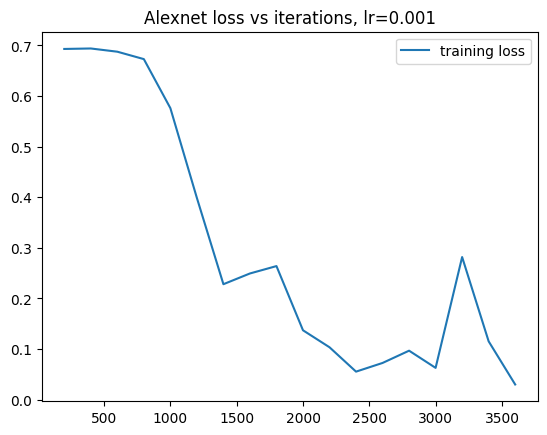

In [25]:
an_loss_list = torch.tensor(an_loss_list, device="cpu")

# Plotting generator and discriminator loss vs iterations
plt.plot(iter_list, an_loss_list, label="training loss")
plt.title(f"Alexnet loss vs iterations, lr={my_lr}")
plt.legend()
plt.show()

# Testing the Model

In [17]:
epoch = 19
my_lr = my_lr

model = Alexnet().to(device)
model.load_state_dict(torch.load(f"an_model_weights_{epoch}_{my_lr}.pth", weights_only=True))
model.eval()

Alexnet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (flat1): Flatten(start_dim=1, end_dim=-1)
  (dense1): Linear(in_features=14400, out_features=256, bias=True)
  (dense2): Linear(in_features=256, out_features=1, bias=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [18]:
from torchsummary import summary

summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 254, 254]             448
         MaxPool2d-2         [-1, 16, 127, 127]               0
            Conv2d-3         [-1, 32, 125, 125]           4,640
         MaxPool2d-4           [-1, 32, 62, 62]               0
            Conv2d-5           [-1, 16, 60, 60]           4,624
         MaxPool2d-6           [-1, 16, 30, 30]               0
           Flatten-7                [-1, 14400]               0
            Linear-8                  [-1, 256]       3,686,656
            Linear-9                    [-1, 1]             257
Total params: 3,696,625
Trainable params: 3,696,625
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 15.26
Params size (MB): 14.10
Estimated Total Size (MB): 30.11
------------------------------------

In [19]:
import sklearn.metrics as metrics

In [20]:
def results_list(model, dataloader, device="cpu"):
    pred_results = []
    true_results = []
    
    for data, labels in tqdm(dataloader):
        images = data.to(device)
        results = model(images)
        
        for i in range(len(data)):
            pred_results.append(results[i].detach().clone())
            true_results.append(labels[i].detach().clone())

    for i in range(len(pred)):
    if pred[i] >.5:
        pred[i] = 1
    else:
        pred[i] = 0
    
    return pred_results, true_results

In [21]:
pred, truth = results_list(model, train_dataloader, device) 

100%|██████████| 189/189 [00:29<00:00,  6.50it/s]


In [23]:
pred = torch.tensor(pred, device="cpu")

In [24]:
metrics.accuracy_score(pred, truth)

0.9734153028163164

# OLD - We will need to modify if we would like to keep these.

In [ ]:
test_image = Image.open(data_path)

In [ ]:
transformed_test_image = transforms_augmented(test_image)
v2.ToPILImage(transformed_test_image)

# convert from (C, H, W) to (H, W, C) for displaying in matplotlib
img_np = transformed_test_image.permute(1, 2, 0).numpy()

# display augmented image
plt.imshow(img_np)
plt.axis('off')
plt.show()